In [ ]:
import numpy as np
from copy import deepcopy
import dionysus as dio
import scipy
import scipy.linalg
import pandas as pd
import gudhi as gd
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt


from Laplacian_Functions_scipy import *
from plot_complex import draw_2d_simplicial_complex, draw_filtration

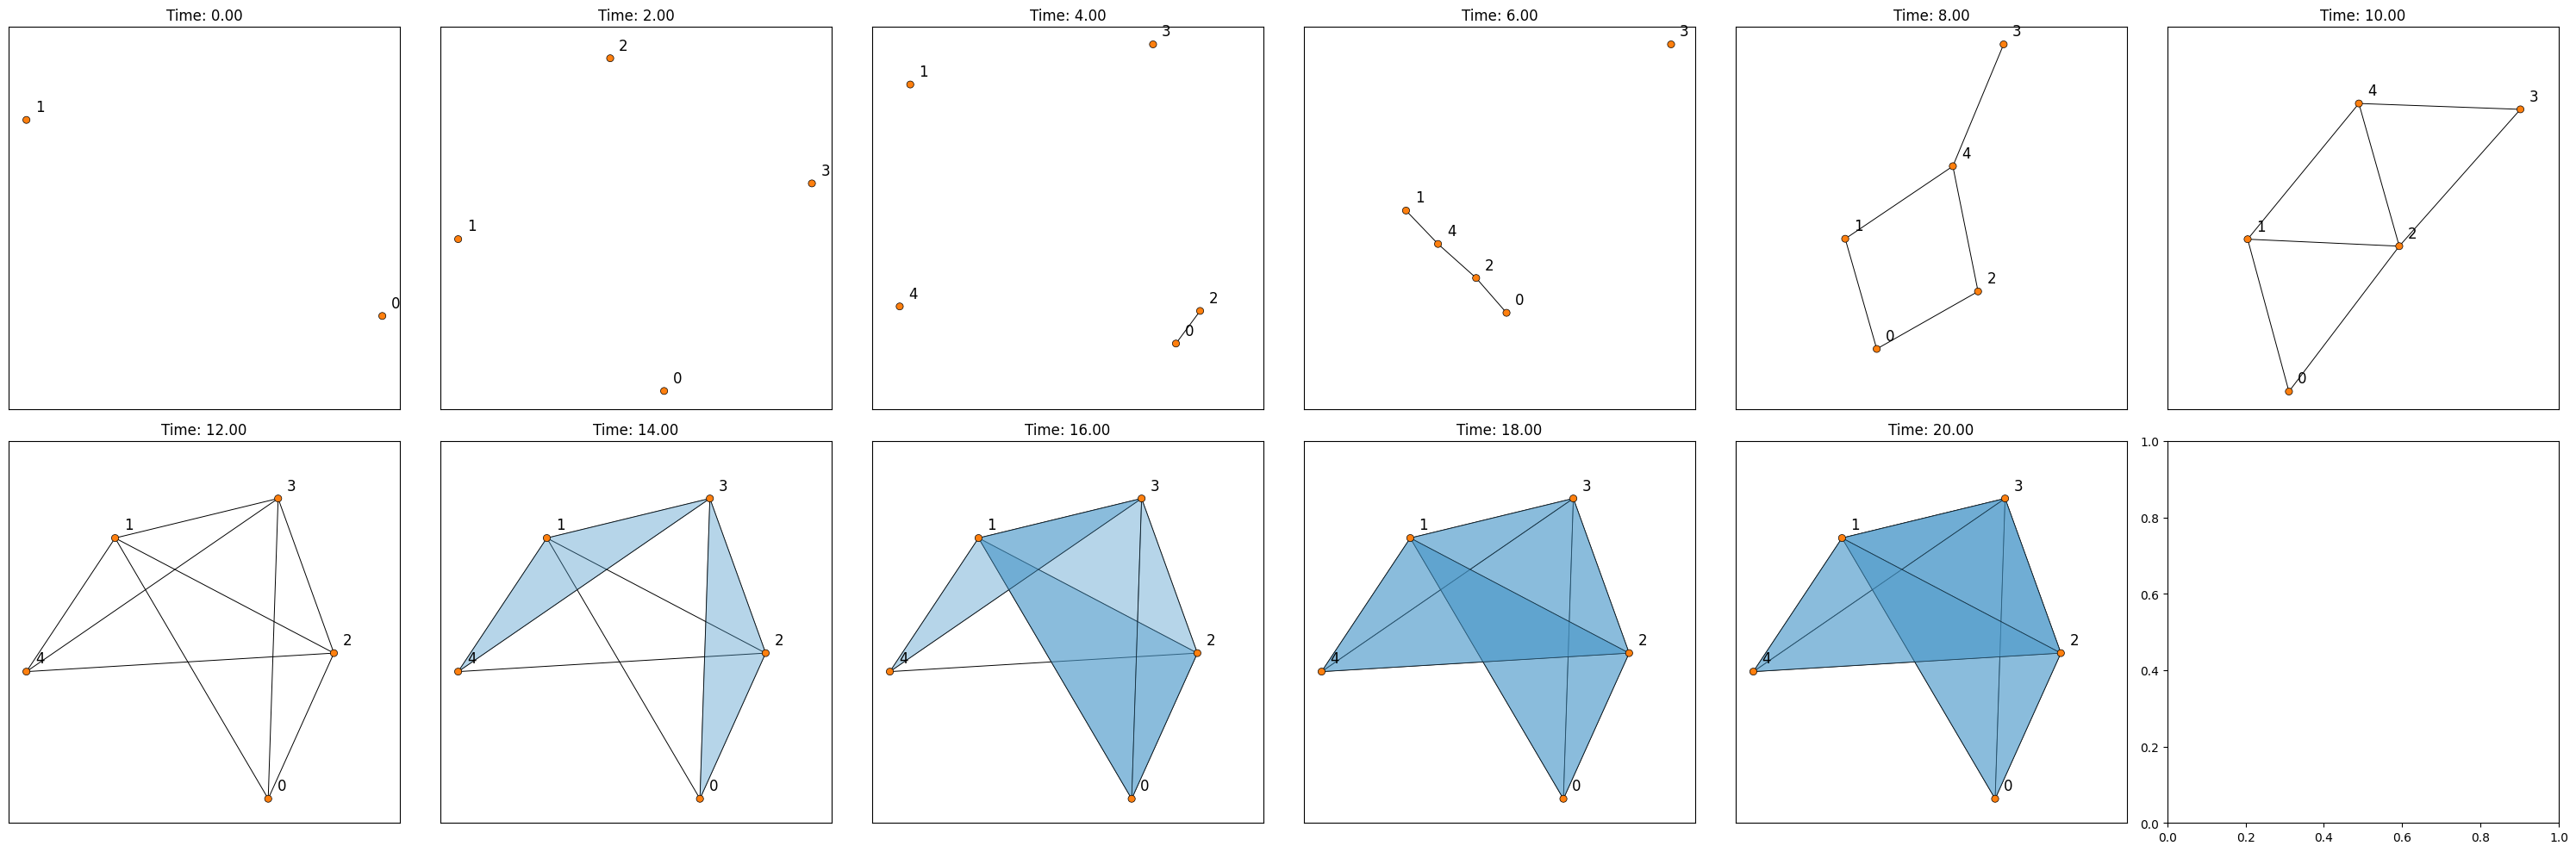

In [ ]:
from venv import create


def create_cycle(n, overlap = 0, start_n=0, overlap_start = 0):
    simplices = []
    for v_i in range(n):
        if v_i < overlap:
            simplices.append(([v_i+overlap_start], 0))
            if v_i + 1 == overlap:
                simplices.append(([v_i+overlap_start, start_n], 1))
            else:
                simplices.append(([v_i+overlap_start, v_i+overlap_start+1], 1))
        elif v_i < n-1:
            simplices.append(([v_i+start_n-overlap], 0))
            simplices.append(([v_i+start_n-overlap, v_i+1+start_n-overlap], 1))
        else:
            simplices.append(([v_i+start_n-overlap], 0))
            # If you started with overlap, go to overlap_start. Otherwise go to start_n.
            simplices.append(([v_i+start_n-overlap, start_n*(overlap==0)+overlap_start*(overlap > 0)], 1))
    return simplices
    
def create_path(n, end_path = -1):
    if end_path < 0:
        end_path += n+1
    simplices = [([0], 0), ([end_path], 1)]
    for i in range(1,n):
        if i < end_path:
            simplices.append(([i], len(simplices)))
        else:
            simplices.append(([i+1], len(simplices)))
    for i in range(end_path-1):
        simplices.append(([i, i+1], len(simplices)))
    for i in range(end_path, n):
        simplices.append(([i, i+1], len(simplices)))
    simplices.append(([end_path-1, end_path], len(simplices)))
    return simplices
    

# Drawn
simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([2,3], 7), ([0,2], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([2,3], 5), ([4], 6), ([2,4], 7), ([3,4], 8), ([2,3,4], 9), ([0,3], 10), ([1,3], 11), ([0,2], 12), ([0,1,3], 13)]#, ([0,2,3], 10)]

# Swapped 7 and 8
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([0,2], 7), ([2,3], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]

# "Flipped"
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([1,2], 5), ([0,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# "Flipped", swapped d and e
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([1,2], 5), ([0,2], 6), ([2,3], 7), ([1,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# "Flipped", swapped b and c
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([0,2], 5), ([1,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# swapped 2 and 3
# simplices = [([0], 0), ([1], 1),  ([3], 2), ([2], 3),([0,1], 4), ([1,2], 5), ([0,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# Non equidistant time intervals
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 8), ([1,3], 10), ([2,3], 10.1), ([0,2], 12), ([0,1,3], 12.5)]

# Ren paper
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,2], 1), ([0,3], 1), ([2,3], 1), ([0,1], 2), ([0,2,3], 3)]

# Drawn new
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 1), ([0,1], 2), ([1,2], 2), ([2,3], 2), ([0,2], 3), ([0,3], 3), ([4], 4), ([2,4], 5), ([3,4], 5), ([0,1,2], 6), ([2,3,4], 7), ([0,2,3], 8)]

# Test easy
# simplices = [([0], 0), ([1], 0), ([2], 0), ([0,1], 0), ([0,2], 0), ([1,2], 0),
#              ([3], 1), ([2,3], 1), ([1,3], 1), ([0,1,2], 1), ([1,2,3], 1)]

# Test hard
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,1], 0), ([0,2], 0), ([1,3], 0), ([2,3], 0),
#               ([1,2], 1),  ([0,1,2], 1), ([1,2,3], 1)]

# Example PowerPoint
# simplices = [([0],0), ([1], 0), ([2], 1), ([3], 1), ([4], 1), ([0,2], 1), ([2,3], 1), ([2,4], 1), ([3,4], 1), ([1,4], 1)]

# Dimension 2 feature
# simplices = [([0],0), ([1], 1), ([0,1], 1), ([2], 2), ([0,2], 2), ([1,2], 2), ([3], 3), ([0,3], 3), ([1,3], 3), ([2,3], 3), ([0,2,3], 4), ([1,2,3], 5), ([0,1,2], 6), ([0,1,3], 7)]

# 2 dimension 2 features
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([4], 4), ([0,2], 5), 
#              ([2,4], 6), ([1,4], 7), ([0,1], 8), ([3,4], 9), ([2,3], 10), ([1,2], 11), 
#              ([1,3], 12), ([0,3], 13), ([0,2,3], 14), ([1,3,4], 15), ([0,1,3], 16), ([0,1,2], 17),
#              ([2,3,4], 18), ([1,2,4], 19), ([1,2,3], 20), ([0,1,2,3], 21)]

# Fewer timesteps
simplices = [([0], 0), ([1], 0), ([2], 2), ([3], 2), ([4], 4), ([0,2], 4), 
             ([2,4], 6), ([1,4], 6), ([0,1], 8), ([3,4], 8), ([2,3], 10), ([1,2], 10), 
             ([1,3], 12), ([0,3], 12), ([0,2,3], 14), ([1,3,4], 14), ([0,1,3], 16), ([0,1,2], 16),
             ([2,3,4], 18), ([1,2,4], 18), ([1,2,3], 20), ([0,1,2,3], 20)]

# NOT 2 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 2), ([0,2], 4), ([0,1], 4),  ([1,2], 3)]

# 2 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 1), ([1,2], 3), ([0,1], 2), ([0,2], 3)]

# 3 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 1), ([3], 1), ([0,3], 2), ([0,1], 2), ([1,2], 2), ([2,3], 2)]

# simplices = [([0], 0), ([3], 1), ([6], 1), ([1], 2), ([0,1], 2), ([4], 2), ([3,4], 2), ([7], 2), ([6,7], 2.5), ([2], 3), ([5], 3), ([8], 3), ([1,2], 3), ([2,3], 4), ([4,5], 4), ([5,6], 4), ([7,8], 4), ([0,8], 4)]

# Path
# simplices = create_path(8, end_path=-1)

# Cycles
# simplices = create_cycle(3)
x = 4
y = 4
z = 4
x4 = 5
overlap = 3
# Three cycles added in order x->y->z, with x and z not connected.
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap, overlap_start=x-overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap, overlap_start=x+y-2*overlap)
# Three cycles added with all of them connecting on overlap vertices.
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)+ create_cycle(x4, start_n=x+y+z-2*overlap, overlap=overlap)
# simplices.append(([7], 0))
# simplices.append(([6,7], 1))
# simplices = create_cycle(7)
# simplices.append(([10], 2))
# simplices.append(([0,2], 2))
# simplices.append(([0,1,2], 2))
# simplices.append(([0,3], 3))
# simplices.append(([0,2,3], 3))
# print(simplices)

f = dio.Filtration()
for vertices, time in simplices:
    f.append(dio.Simplex(vertices, time))

draw_filtration(f)

# Drawing graph
# G = nx.Graph()
# f.sort()
# for s in f:
#     if s.dimension() == 0:
#         G.add_node(s[0])
#     elif s.dimension() == 1:
#         G.add_edge(s[0], s[1])
# nx.draw_planar(G, with_labels=True)

Computing boundary matrices:   0%|          | 0/22 [00:00<?, ?it/s]

Computing boundary matrices done.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

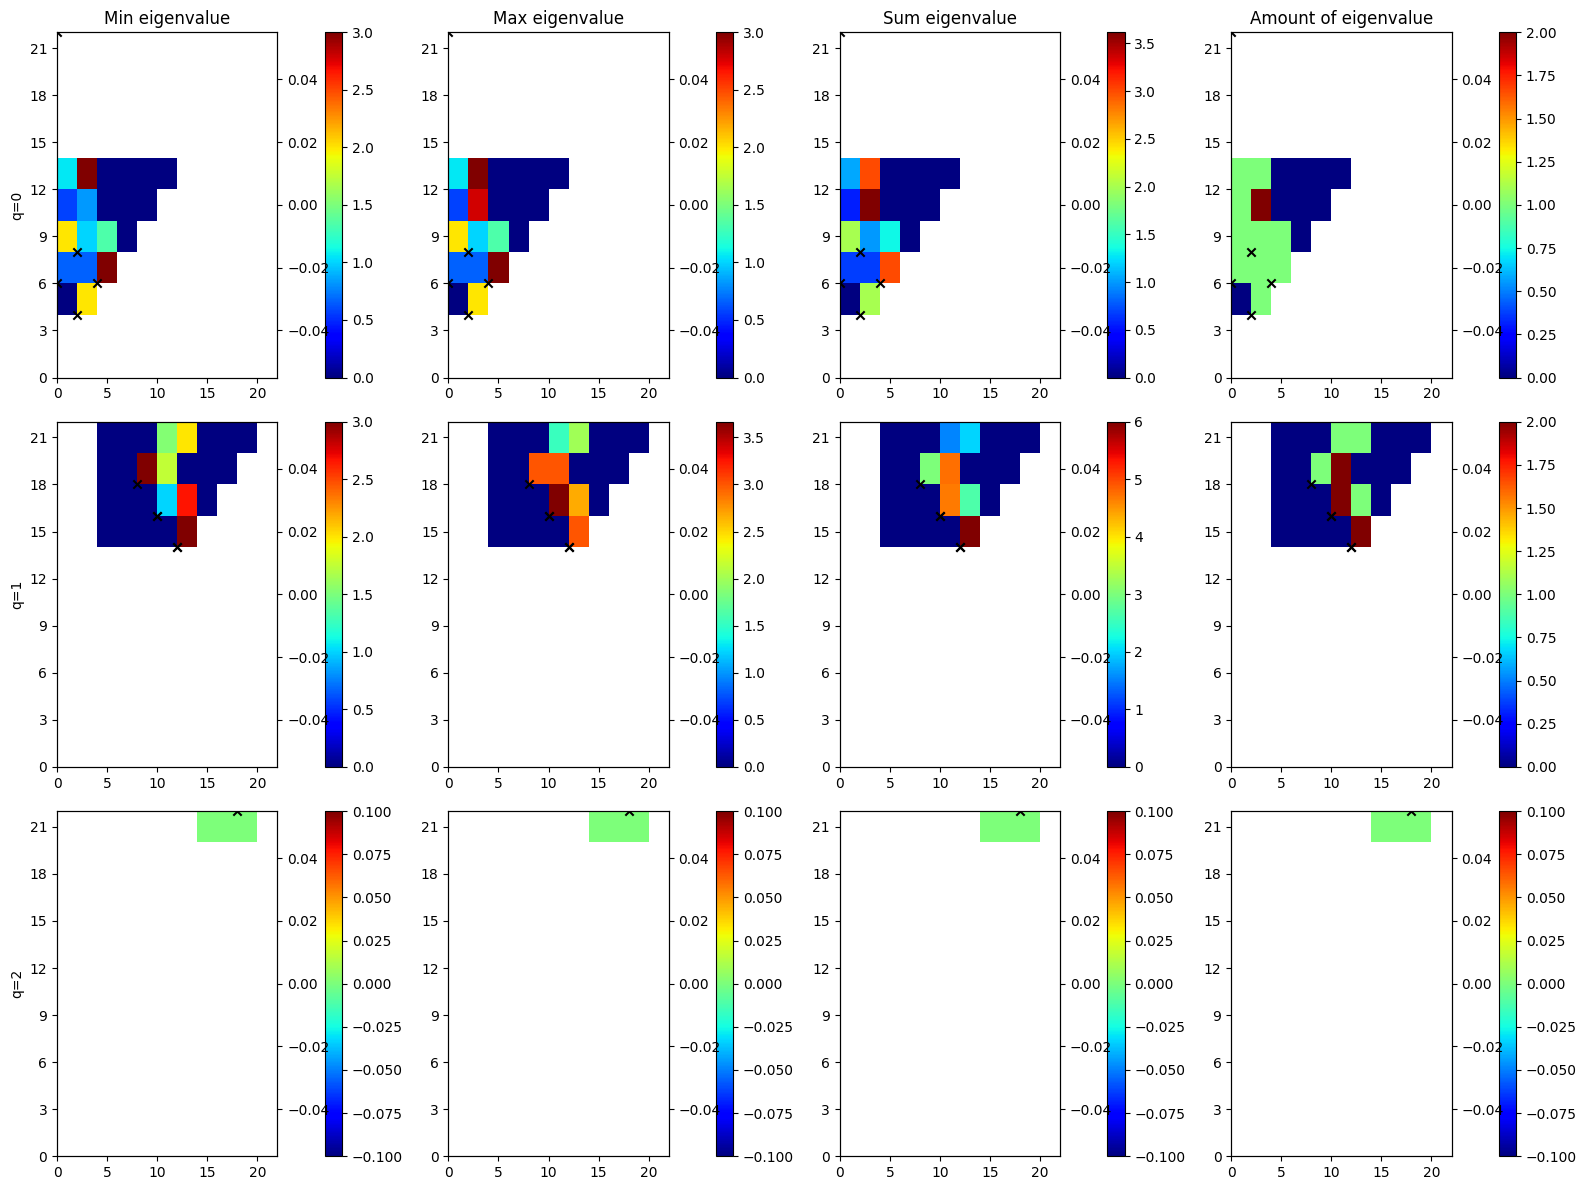

In [3]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    return B22_sm1t@B22_stm1-B22_st
    # return B22_stm1@B22_sm1t-B22_st

    # Normal
    # return -1*(B22_sm1tm1 - B22_sm1t - B22_stm1 + B22_st)

    # return B22_sm1t - B22_st

eigenvalues, relevant_times, fig, ax = plot_Laplacian_new_eigenvalues(f, lambda x: 1, max_dim =2, plot_types=["Min", "Max", "Sum", "Amount of"], Laplacian_fun= Laplacian_fun, method="fast", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len}, integer_time_steps=True, sparse_type="csr")

In [4]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    return B22_sm1t@B22_stm1-B22_st
    # return B22_stm1@B22_sm1t-B22_st

    # Normal
    # return -1*(B22_sm1tm1 - B22_sm1t - B22_stm1 + B22_st)

    # return B22_sm1t - B22_st
    
cross_Lap = calc_cross(f, 1, 10, 16, verb=True, Laplacian_fun = Laplacian_fun, sparse_type="csc")
print(cross_Lap.format)
cross_Lap.toarray()

Computing boundary matrices:   0%|          | 0/22 [00:00<?, ?it/s]

Computing boundary matrices done.
Boundary type: csc
Bqplus1:
  (0, 0)	1.0
  (6, 0)	1.0
  (7, 0)	-1.0
  (1, 1)	-1.0
  (4, 1)	1.0
  (8, 1)	1.0
  (0, 2)	-1.0
  (3, 2)	1.0
  (5, 2)	1.0
  (3, 3)	1.0
  (7, 3)	-1.0
  (8, 3)	1.0
  (1, 4)	-1.0
  (2, 4)	1.0
  (5, 4)	1.0
  (2, 5)	-1.0
  (4, 5)	1.0
  (6, 5)	1.0
  (5, 6)	1.0
  (6, 6)	1.0
  (8, 6)	-1.0
n_q_t:[5, 9, 4, 0, 0], n_q_s: [5, 7, 0, 0, 0]
B12_st:
  (0, 0)	1.0
  (6, 0)	1.0
  (1, 1)	-1.0
  (4, 1)	1.0
  (0, 2)	-1.0
  (3, 2)	1.0
  (5, 2)	1.0
  (3, 3)	1.0
B22_st:
  (0, 0)	-1.0
  (1, 1)	1.0
  (0, 3)	-1.0
  (1, 3)	1.0
B22_stm1:
  (0, 0)	-1.0
  (1, 1)	1.0
B22_sm1t:
  (1, 0)	1.0
  (2, 0)	-1.0
  (3, 1)	1.0
  (0, 2)	1.0
  (2, 3)	-1.0
  (3, 3)	1.0
B22_sm1tm1:
  (1, 0)	1.0
  (2, 0)	-1.0
  (3, 1)	1.0
A_matrix:
[[ 1.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]]
B22_st_full:
  (0, 0)	0.6666700000000001
  (1, 0)	-0.33333
  (3, 0)	0.33333
  (0, 1)	-0.33333
  (1, 1)	0.66667000

/home/siroj/miniconda3/envs/thesis/lib/python3.9/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


array([[ 1.33333333, -0.33333333,  0.        , -1.33333333,  0.33333333,
        -1.        ,  0.33333333],
       [-0.33333333,  0.33333333,  0.        ,  0.33333333, -0.33333333,
         0.        , -0.33333333],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-1.33333333,  0.33333333,  0.        ,  1.33333333, -0.33333333,
         1.        , -0.33333333],
       [ 0.33333333, -0.33333333,  0.        , -0.33333333,  0.33333333,
         0.        ,  0.33333333],
       [-1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ],
       [ 0.33333333, -0.33333333,  0.        , -0.33333333,  0.33333333,
         0.        ,  0.33333333]])

In [ ]:
test_m = cross_Lap[:3, :3]
test_m._shape = (4,4)
test_m.indptr = np.append(test_m.indptr, test_m.indptr[-1]+1)
# test_m[3,3] = 1
test_m.indices = np.append(test_m.indices, 3)
test_m.data = np.append(test_m.data, 1)

print(test_m.toarray())
test_m.indices

[[ 1.33333333 -0.33333333  0.          0.        ]
 [-0.33333333  0.33333333  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]


array([1, 0, 0, 1, 3])

In [ ]:
from hmac import new




In [19]:
test_m = cross_Lap[:2, :3]
test_m[0, 2] = 1
print(type(test_m))
print(test_m.toarray())
print("indices:", test_m.indices)
print("data:", test_m.data)
print("indptr:", test_m.indptr)
extend_with_zeros(test_m, new_shape=(2, 4), ori_matrix_in_bottom_right=False)
print("indptr:", test_m.indptr)
print(test_m.toarray())
test_m.indices

<class 'scipy.sparse._csc.csc_array'>
[[ 1.33333333 -0.33333333  1.        ]
 [-0.33333333  0.33333333  0.        ]]
indices: [0 1 0 1 0]
data: [ 1.33333333 -0.33333333 -0.33333333  0.33333333  1.        ]
indptr: [0 2 4 5]
indptr: [0 2 4 5 5]
[[ 1.33333333 -0.33333333  1.          0.        ]
 [-0.33333333  0.33333333  0.          0.        ]]


array([0, 1, 0, 1, 0], dtype=int32)

In [5]:
q = 1
s = 6
t = 14
sm1 = 4
B22 = boundary_matrices[q+1][simplices_at_time(sm1)[q]:simplices_at_time(t)[q], simplices_at_time(sm1)[q+1]:simplices_at_time(t)[q+1]]

def sparse_pinv(A):
    u, s, vh = spla.svds(A, k = min(A.shape)-1, solver="lobpcg", tol=1e-10, ncv=min(A.shape))
    u = sp.csr_matrix(np.round(u, 10)).T
    s = sp.diags(s**(-1), format="csr")
    vh = sp.csr_matrix(np.round(vh, 10)).T
    return vh@s@u



NameError: name 'boundary_matrices' is not defined

In [6]:
sparse_pinv(B22).toarray()

NameError: name 'sparse_pinv' is not defined

In [7]:
def pinv(A):
    return sp.csc_matrix(np.round(np.linalg.pinv(A.toarray()), 13))

B22_inv = pinv(B22)
B22_inv.toarray()

NameError: name 'B22' is not defined

In [26]:
B22_full = B22_inv@B22
# B22_full._shape = (3,3)
# # B22_full.indptr += 1
# # B22_full.indptr = np.hstack((B22_full.indptr, B22_full.indptr[-1]))
# B22_full.indices += 1
# B22_full.indptr = np.array([0,0,1,2], dtype=np.int32)
# B22_full.toarray() 
B22_full.toarray()


array([[1., 0.],
       [0., 1.]])

In [28]:
sp.vstack([B22, B22_full]).toarray()

array([[ 0., -1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 1.,  0.],
       [-1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [45]:
B22_full.indices

array([1, 1, 0, 0, 1], dtype=int32)

In [10]:
B22_full.indptr = np.array([0,1,2], dtype=np.int32)
B22_full.toarray() 

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [49]:
def poissonPointProcess(intensity, xMin=0, xMax=1, yMin=0, yMax=1, plot=False, seed=None):
    xDelta=xMax-xMin;yDelta=yMax-yMin #rectangle dimensions
    areaTotal=xDelta*yDelta
    if seed is not None:
        np.random.seed(seed) #set the random seed for reproducibility

    #Simulate a Poisson point process
    numbPoints = np.random.poisson(intensity*areaTotal);#Poisson number of points
    xx = xDelta*np.random.uniform(0,1,numbPoints)+xMin;#x coordinates of Poisson points
    yy = yDelta*np.random.uniform(0,1,numbPoints)+yMin;#y coordinates of Poisson points

    #Plot the points
    if plot:
        plt.figure()
        plt.scatter(xx,yy,s=2)
        plt.xlim(xMin,xMax)
        plt.ylim(yMin,yMax)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Poisson Point Process, n={numbPoints}')
        plt.show()
    return xx,yy


In [ ]:
xx, yy = poissonPointProcess(500, seed=123, plot=False)
max_r = 0.05
f = dio.fill_rips(np.array([xx, yy]).T, 2, max_r)
print(f)
f.sort()
# p = dio.cohomology_persistence(f, 47, True)
# dgms = dio.init_diagrams(p, f)
# dio.plot.plot_all_diagrams(dgms, limits=[0, max_r, 0, max_r])
boundary_matrices, name_to_idx, simplices_at_time, relevant_times = compute_boundary_matrices(f, lambda _: 1, sparse_type = "csr")

Filtration with 2303 simplices


Computing boundary matrices:   0%|          | 0/2303 [00:00<?, ?it/s]

/home/siroj/miniconda3/envs/thesis/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Computing boundary matrices done.


In [54]:
len(relevant_times)

1002

In [67]:
q = 1
s = relevant_times[200]
t = relevant_times[700]
sm1 = relevant_times[199]
B22 = boundary_matrices[q+1][simplices_at_time(sm1)[q]:simplices_at_time(t)[q], simplices_at_time(sm1)[q+1]:simplices_at_time(t)[q+1]]
B22

<501x347 sparse matrix of type '<class 'numpy.float64'>'
	with 700 stored elements in Compressed Sparse Row format>

In [112]:
sparse_pinv(B22)

<347x501 sparse matrix of type '<class 'numpy.float64'>'
	with 97937 stored elements in Compressed Sparse Column format>

In [104]:
pinv(B22)

<347x501 sparse matrix of type '<class 'numpy.float64'>'
	with 109444 stored elements in Compressed Sparse Row format>